# Convolutional Neural Network (CNN)

### Import TensorFlow

In [273]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [274]:
import numpy as np 
import pandas as pd 
#from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from glob import glob
import os
import matplotlib.pyplot as plt
from pandas import DataFrame

### Load the dataset

In [275]:
bishop = glob('data/Bishop/*.jpg')
king = glob('data/Bishop/*.jpg')
knight = glob('data/Bishop/*.jpg')
pawn = glob('data/Bishop/*.jpg')
queen = glob('data/Bishop/*.jpg')
rook = glob('data/rook/*.jpg')



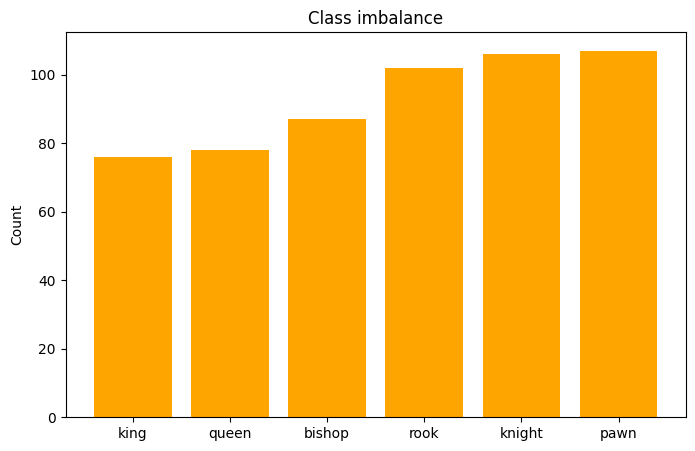

In [276]:
labels = ['bishop', 'king', 'knight', 'pawn', 'queen', 'rook']
label_counts = dict()
for class_label in labels:
  label_counts[class_label] = len(os.listdir(f'data/{class_label}/'))

label_counts = dict(sorted(label_counts.items(), key=lambda x: x[1]))

fig, ax = plt.subplots(figsize=(8,5))
plt.bar(list(label_counts.keys()), list(label_counts.values()), color ='orange')
plt.xlabel('') 
plt.ylabel('Count') 
ax.set_xticks(list(label_counts.keys()))
plt.title('Class imbalance') 

plt.show()

In [277]:
models_accuracy = dict()

In [278]:
def extract_class_weights():
    class_names = ['bishop', 'king', 'knight', 'pawn', 'queen', 'rook']
    
    class_counts = dict()
    for name in class_names:
        class_counts[name] = len(os.listdir('data/' + name))
    
    total = sum(class_counts.values())
    num_classes = len(class_names)
    
    class_weights = dict()
    for i in range(num_classes):
        class_weights[i] = total / (num_classes * list(class_counts.values())[i])
        print('{} {}: {:.2}'.format(i+1, class_names[i], class_weights[i]))
        
    return class_weights

extract_class_weights()

1 bishop: 1.1
2 king: 1.2
3 knight: 0.87
4 pawn: 0.87
5 queen: 1.2
6 rook: 0.91


{0: 1.0651340996168583,
 1: 1.219298245614035,
 2: 0.8742138364779874,
 3: 0.8660436137071651,
 4: 1.188034188034188,
 5: 0.9084967320261438}

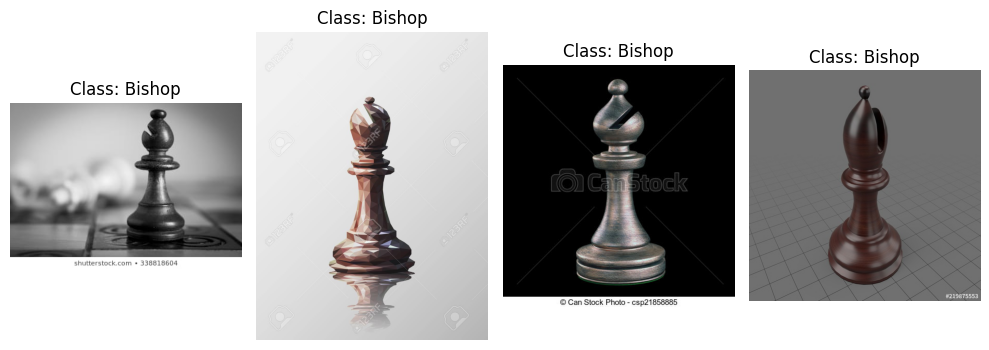

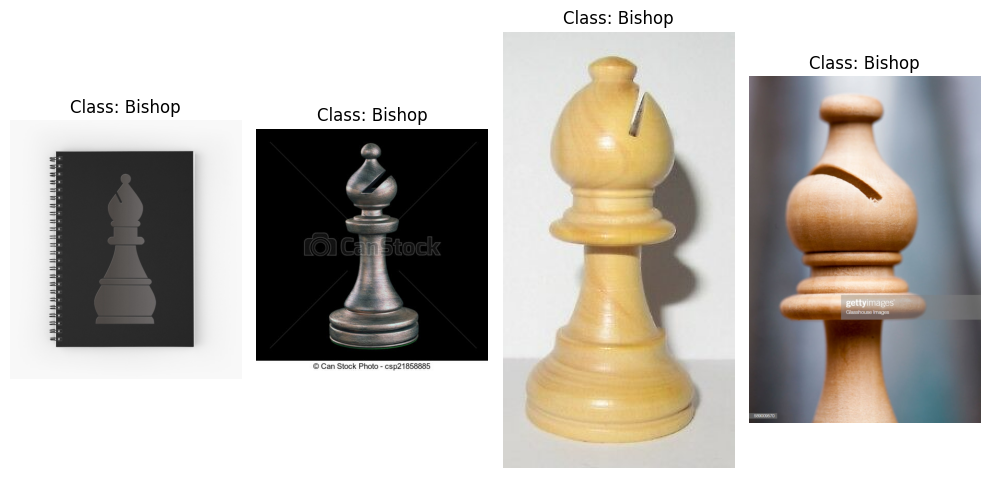

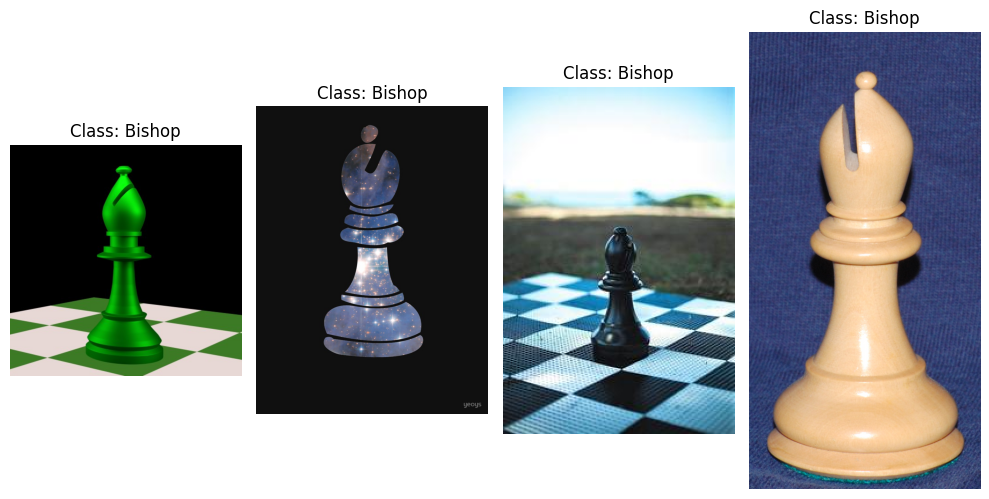

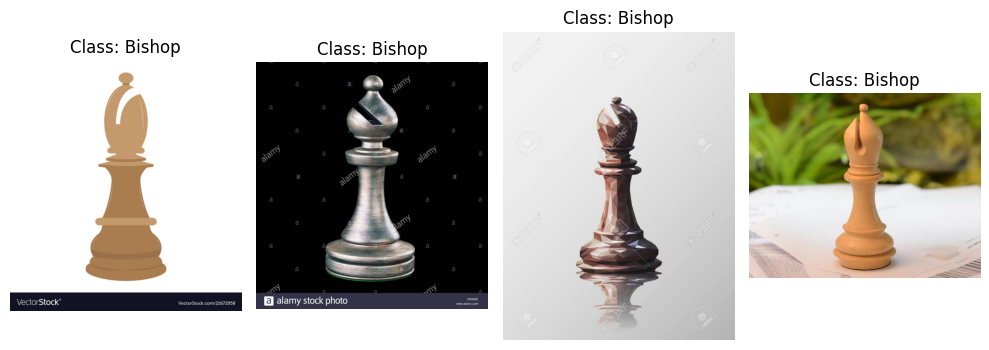

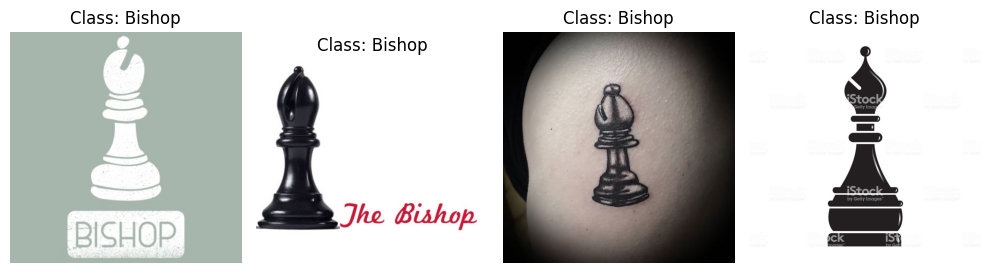

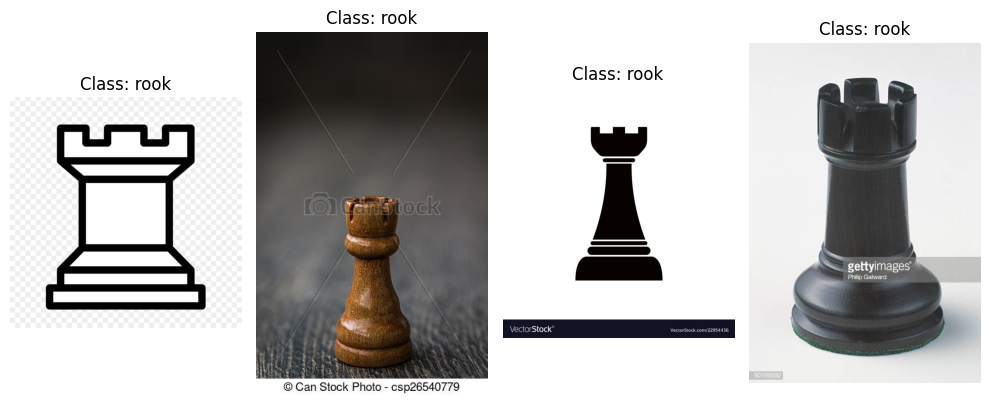

In [279]:

def display_images(label):
    import random
    from matplotlib.image import imread
    from pathlib import PurePath
    
    fig, axs = plt.subplots(1, 4, figsize=(10, 6), tight_layout=True)
    axs = axs.ravel()
    

    img_list = random.sample(label, 4)
    
    for i, img_path in enumerate(img_list):
        img = imread(img_path)
        label = PurePath(img_path).parent.name
        axs[i].set_title(f'Class: {label}', fontsize=12)
        axs[i].imshow(img, cmap='magma')
        axs[i].axis('off')
    plt.show()
    
display_images(bishop)
display_images(king)
display_images(knight)
display_images(pawn)
display_images(queen)
display_images(rook)

In [280]:
import numpy as np

resized_image_array = []
resized_image_array_label = []

SIZE = 32

def resize_images(image_directory):
    from PIL import Image
    
    target_size = (SIZE, SIZE)
    
    for file in image_directory:
        img = Image.open(file)

        img = img.convert('L')
        
        img = img.resize(target_size)
        array_temp = np.array(img)
        
        shape_new = SIZE * SIZE
        img_wide = array_temp.reshape(1, shape_new)
        resized_image_array.append(img_wide[0])
        
        if image_directory == bishop:
            resized_image_array_label.append(0)
        elif image_directory == king:
            resized_image_array_label.append(1)
        elif image_directory == knight:
            resized_image_array_label.append(2)
        elif image_directory == pawn:
            resized_image_array_label.append(3)
        elif image_directory == queen:
            resized_image_array_label.append(4)
        elif image_directory == rook:
            resized_image_array_label.append(5)
            
resize_images(bishop)
resize_images(king)
resize_images(knight)
resize_images(pawn)
resize_images(queen)
resize_images(rook)

from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(resized_image_array, resized_image_array_label,
                                                    test_size=0.2, shuffle=True, random_state=7)

train_images = np.array(train_images)   
train_images = train_images.reshape(-1, SIZE, SIZE, 1)

test_images = np.array(test_images)
test_images = test_images.reshape(-1, SIZE, SIZE, 1)


train_labels = np.array(train_labels)
test_labels = np.array(test_labels)



In [281]:
#(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
#train_images, test_images = train_images / 255.0, test_images / 255.0

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


In [282]:
'''class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()
'''

"class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',\n               'dog', 'frog', 'horse', 'ship', 'truck']\n\nplt.figure(figsize=(10,10))\nfor i in range(25):\n    plt.subplot(5,5,i+1)\n    plt.xticks([])\n    plt.yticks([])\n    plt.grid(False)\n    plt.imshow(train_images[i])\n    # The CIFAR labels happen to be arrays,\n    # which is why you need the extra index\n    plt.xlabel(class_names[train_labels[i][0]])\nplt.show()\n"

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [283]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(SIZE, SIZE, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(48, (3, 3), activation='relu'))

Let's display the architecture of your model so far:

In [284]:
model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_80 (Conv2D)              │ (None, 30, 30, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 4, 4, 48)       │        13,872 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,672 (72.94 KB)

 Trainable params: 18,672 (72.94 KB)

 Non-trainable params: 0 (0.00 B)

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [285]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6))
model.add(layers.Dense(6, activation='softmax'))


Here's the complete architecture of your model:

In [286]:
model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_80 (Conv2D)              │ (None, 30, 30, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 4, 4, 48)       │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_37 (Flatten)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 6)              │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 6)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,320 (266.88 KB)

 Trainable params: 68,320 (266.88 KB)

 Non-trainable params: 0 (0.00 B)

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [287]:
import tensorflow as tf

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

history = model.fit(train_images, train_labels, epochs=25,
                    validation_data=(test_images, test_labels))

(353, 32, 32, 1)
(353,)
(89, 32, 32, 1)
(89,)
Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4161 - loss: 13.2185 - val_accuracy: 0.5955 - val_loss: 1.0984
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7664 - loss: 1.0094 - val_accuracy: 0.7079 - val_loss: 0.8879
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7942 - loss: 0.6278 - val_accuracy: 0.6966 - val_loss: 0.6297
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8044 - loss: 0.4382 - val_accuracy: 0.8315 - val_loss: 0.6022
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9176 - loss: 0.2452 - val_accuracy: 0.8764 - val_loss: 0.5186
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9066 - loss: 0.2260 - val_accuracy: 0.8764 - val_loss: 0.4303
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9422 - loss: 0.1805 - val_accuracy: 0.8764 - val_loss: 0.4648
Epoch 8/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9299 -

### Evaluate the model

3/3 - 0s - 6ms/step - accuracy: 0.9213 - loss: 0.2624


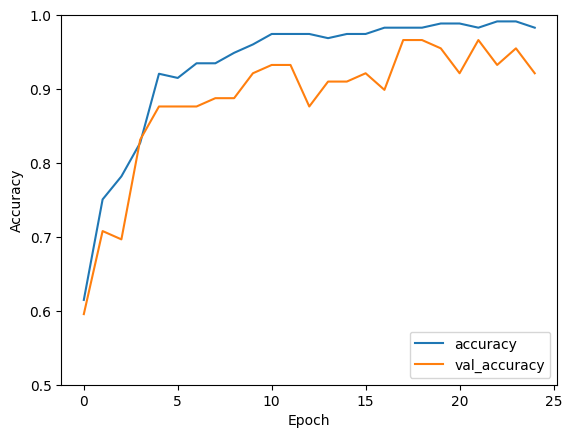

In [288]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [289]:
print(test_acc)

0.9213483333587646


Your simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, check out the [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) example that uses the Keras subclassing API and `tf.GradientTape`.